In [1]:
import pandas as pd
import numpy as np

# 导入样本

In [2]:
model_vars = pd.read_csv('model_vars.csv')
transaction_risk_sample = pd.read_excel('transaction_risk_sample.xlsx')
transaction_risk_score_sample = pd.read_excel('transaction_risk_score_sample.xlsx')

# 查看数据维度

In [3]:
#查询数据集格式
model_vars.head(2)

uid  time_sinc_login_sec  timelong_lst_login  log_from_lst_login  \
0   10                   95                4225                   1   
1  100              2045842                9000                   2   

   city_lst_login  result_lst_login  type_lst_login  scan_login_lst_login  \
0             336                 1               3                     0   
1             142                 1               3                     0   

   security_login_lst_login  cnt_login       ...        cnt_sec1_login  \
0                         0          3       ...                     0   
1                         0          1       ...                     0   

   cnt_sec0_login  rat_timelong_lst_avg  rat_result1_login  rat_type1_login  \
0               3              1.011976                1.0              0.0   
1               1              1.000000                1.0              0.0   

   rat_type2_login  rat_type3_login  rat_scan1_login  rat_scan0_login  \
0              0.0              1.0              0.0              1.0   
1              0.0              1.0              0.0              1.0   

   rat_sec1_login  
0             0.0  
1             0.0  

[2 rows x 32 columns]

In [4]:
#查看数据行列量
model_vars.shape

(24737, 32)

In [5]:
#设置数据框展示列数，此步可省略
pd.set_option( 'display.max_columns' , 100)

In [6]:
transaction_risk_score_sample.head(2)

uid transaction_datetime
0    2  2015-04-01 12:06:11
1    7  2015-06-12 15:23:40

In [7]:
transaction_risk_sample.head(2)

uid sample transaction_datetime  target
0    3    trn  2015-01-08 15:00:25       0
1    4    oos  2015-06-18 11:51:29       0

In [8]:
#拼接样本特征与样本结果
transaction_risk_sample = transaction_risk_sample.merge(model_vars, on = 'uid', how = 'left')

In [9]:
#拼接预测集特征
transaction_risk_score_sample = transaction_risk_score_sample.merge(model_vars, on = 'uid', how = 'left')

In [10]:
#为保持训练样本与推断样本格式一致，做列的增删处理，此处推断样本中没有sample列故删除
del transaction_risk_sample['sample']

In [11]:
transaction_risk_score_sample.shape

(4947, 33)

In [12]:
transaction_risk_sample.shape

(19790, 34)

In [13]:
#观察训练样本里0/1分布情况，可省略
transaction_risk_sample['target'].value_counts()

0    19133
1      657
Name: target, dtype: int64

In [14]:
#数据集信息探索
transaction_risk_sample.describe()

uid        target  time_sinc_login_sec  timelong_lst_login  \
count  19790.000000  19790.000000         1.979000e+04        1.979000e+04   
mean   13011.375088      0.033199         4.809186e+05        3.140392e+04   
std     7512.087332      0.179159         1.424994e+06        1.608942e+06   
min        3.000000      0.000000         8.000000e+00        0.000000e+00   
25%     6529.500000      0.000000         5.192500e+02        5.000000e+03   
50%    13014.500000      0.000000         2.530500e+03        7.796000e+03   
75%    19501.750000      0.000000         1.827262e+05        1.470400e+04   
max    26044.000000      1.000000         1.487268e+07        2.253800e+08   

       log_from_lst_login  city_lst_login  result_lst_login  type_lst_login  \
count        19790.000000    19790.000000      19790.000000    19790.000000   
mean             1.593482      235.681758          1.056796        2.175493   
std              0.634647      126.550241          0.367743        0.944076   
min              1.000000        1.000000          1.000000        1.000000   
25%              1.000000      134.000000          1.000000        1.000000   
50%              2.000000      265.000000          1.000000        3.000000   
75%              2.000000      348.000000          1.000000        3.000000   
max              5.000000      454.000000          5.000000        3.000000   

       scan_login_lst_login  security_login_lst_login     cnt_login  \
count          19790.000000                   19790.0  19790.000000   
mean               0.069378                       0.0     11.328449   
std                0.254103                       0.0     29.425749   
min                0.000000                       0.0      1.000000   
25%                0.000000                       0.0      2.000000   
50%                0.000000                       0.0      4.000000   
75%                0.000000                       0.0     11.000000   
max                1.000000                       0.0   1388.000000   

       sum_timelong  avg_timelong  cnt_log_from        cnt_ip      cnt_city  \
count  1.979000e+04  1.979000e+04  19790.000000  19790.000000  19790.000000   
mean   2.856791e+05  3.147441e+04      1.522486      5.173421      1.929661   
std    8.133210e+06  1.605771e+06      0.633010      9.713519      1.669373   
min    0.000000e+00  0.000000e+00      1.000000      1.000000      1.000000   
25%    1.400000e+04  5.666667e+03      1.000000      1.000000      1.000000   
50%    4.230800e+04  9.008206e+03      1.000000      2.000000      1.000000   
75%    1.520802e+05  1.688099e+04      2.000000      5.000000      2.000000   
max    1.126623e+09  2.253247e+08      4.000000    313.000000     38.000000   

         cnt_result  cnt_result1_login  cnt_type1_login  cnt_type2_login  \
count  19790.000000       19790.000000     19790.000000     19790.000000   
mean       1.636433           8.980950         4.388277         1.137645   
std        0.734953          27.461335        21.366301         7.207609   
min        1.000000           0.000000         0.000000         0.000000   
25%        1.000000           1.000000         0.000000         0.000000   
50%        1.000000           3.000000         0.000000         0.000000   
75%        2.000000           7.000000         2.000000         0.000000   
max        5.000000        1363.000000      1384.000000       356.000000   

       cnt_type3_login  cnt_scan1_login  cnt_scan0_login  cnt_sec1_login  \
count     19790.000000     19790.000000     19790.000000         19790.0   
mean          5.802527         0.437494        10.890955             0.0   
std          19.329292         2.380482        29.187999             0.0   
min           0.000000         0.000000         0.000000             0.0   
25%           0.000000         0.000000         2.000000             0.0   
50%           1.000000         0.000000         4.000000             0.0   
75%           5.000000         0

In [15]:
#数据集信息观察
transaction_risk_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19790 entries, 0 to 19789
Data columns (total 34 columns):
uid                         19790 non-null int64
transaction_datetime        19790 non-null object
target                      19790 non-null int64
time_sinc_login_sec         19790 non-null int64
timelong_lst_login          19790 non-null int64
log_from_lst_login          19790 non-null int64
city_lst_login              19790 non-null int64
result_lst_login            19790 non-null int64
type_lst_login              19790 non-null int64
scan_login_lst_login        19790 non-null int64
security_login_lst_login    19790 non-null int64
cnt_login                   19790 non-null int64
sum_timelong                19790 non-null float64
avg_timelong                19790 non-null float64
cnt_log_from                19790 non-null int64
cnt_ip                      19790 non-null int64
cnt_city                    19790 non-null int64
cnt_result                  19790 non-null int64
cnt_

# 分析特征变量

In [16]:
#交易时间探索，检查训练集和样本集的日期分布规律，早中晚分布规律，一致性等，略

In [18]:
#将变量名转换为列表形式，便于后续进行循环操作，必要
var_all = transaction_risk_sample.columns.tolist()

In [19]:
#检查是否空值，必要
for col in var_all:
    x = transaction_risk_sample[col].isnull().sum()
    if x != 0:
        print(col, x)

rat_timelong_lst_avg 47


In [22]:
#填充空值,用均值填充,同步完成预测集填充,必要
rat_timelong_lst_avg_mean = np.mean(transaction_risk_sample['rat_timelong_lst_avg'])
transaction_risk_sample['rat_timelong_lst_avg'].fillna(rat_timelong_lst_avg_mean, inplace = True) #对训练集补充空值
transaction_risk_score_sample['rat_timelong_lst_avg'].fillna(rat_timelong_lst_avg_mean, inplace = True) #对训练集补充空值

In [23]:
#观察到所有的变量都是数值型（原数据未给出具体变量信息，只能从数据类型上判断）
#由于未给出具体变量信息，无法判断是否异常值，故此处不做异常值处理

In [24]:
transaction_risk_sample.groupby(['cnt_result', 'target']).size()

cnt_result  target
1           0         9638
            1          286
2           0         7214
            1          235
3           0         2002
            1          117
4           0          266
            1           18
5           0           13
            1            1
dtype: int64

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

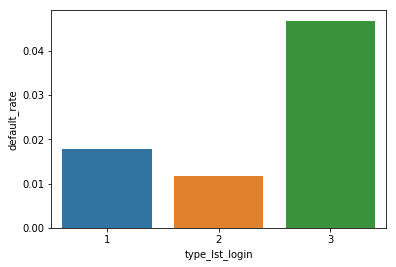

In [26]:
#画图探索每组违约率差异，非必要
df = pd.DataFrame()
df['total'] = transaction_risk_sample.groupby(['type_lst_login'])['target'].count() #计算每组的总数
df['bad'] = transaction_risk_sample.groupby(['type_lst_login'])['target'].sum() #计算每组违约总数
df['default_rate'] = df['bad']/df['total'] #计算每组违约率
df = df.reset_index()
sns.barplot(data = df, x = 'type_lst_login', y = 'default_rate')

In [31]:
transaction_risk_sample.head(2)

uid transaction_datetime  target  time_sinc_login_sec  timelong_lst_login  \
0    3  2015-01-08 15:00:25       0                 1582                2000   
1    4  2015-06-18 11:51:29       0                  366                7702   

   log_from_lst_login  city_lst_login  result_lst_login  type_lst_login  \
0                   2              33                 1               3   
1                   1             435                 1               1   

   scan_login_lst_login  security_login_lst_login  cnt_login  sum_timelong  \
0                     0                         0          1        2000.0   
1                     0                         0          3       30256.0   

   avg_timelong  cnt_log_from  cnt_ip  cnt_city  cnt_result  \
0   2000.000000             1       1         1           1   
1  10085.333333             1       3         1           1   

   cnt_result1_login  cnt_type1_login  cnt_type2_login  cnt_type3_login  \
0                  1                0                0                1   
1                  3                3                0                0   

   cnt_scan1_login  cnt_scan0_login  cnt_sec1_login  cnt_sec0_login  \
0                0                1               0               1   
1                0                3               0               3   

   rat_timelong_lst_avg  rat_result1_login  rat_type1_login  rat_type2_login  \
0              1.000000                1.0              0.0              0.0   
1              0.763683                1.0              1.0              0.0   

   rat_type3_login  rat_scan1_login  rat_scan0_login  rat_sec1_login  
0              1.0              0.0              1.0             0.0  
1              0.0              0.0              1.0             0.0

In [32]:
#数据探索,对于连续变量,做箱线图，观察数据分布。
var_num = []
for col in transaction_risk_sample.columns:
    x =  transaction_risk_sample[].nunique() #观察每个变量里有多少个不同的值
    print(col, x)
    var_num.append(col)

uid 19790
transaction_datetime 19737
target 2
time_sinc_login_sec 11759
timelong_lst_login 8526
log_from_lst_login 5
city_lst_login 388
result_lst_login 5
type_lst_login 3
scan_login_lst_login 2
security_login_lst_login 1
cnt_login 239
sum_timelong 13280
avg_timelong 13749
cnt_log_from 4
cnt_ip 118
cnt_city 24
cnt_result 5
cnt_result1_login 230
cnt_type1_login 185
cnt_type2_login 95
cnt_type3_login 172
cnt_scan1_login 46
cnt_scan0_login 241
cnt_sec1_login 1
cnt_sec0_login 239
rat_timelong_lst_avg 12987
rat_result1_login 899
rat_type1_login 580
rat_type2_login 325
rat_type3_login 581
rat_scan1_login 356
rat_scan0_login 356
rat_sec1_login 1


{'whiskers': [<matplotlib.lines.Line2D at 0x2079fdfadd8>,
 'caps': [<matplotlib.lines.Line2D at 0x2079fdf1a20>,
 'boxes': [<matplotlib.lines.Line2D at 0x2079fdfac88>],
 'medians': [<matplotlib.lines.Line2D at 0x2079fdf1ef0>],
 'fliers': [<matplotlib.lines.Line2D at 0x207a00a76d8>],
 'means': []}

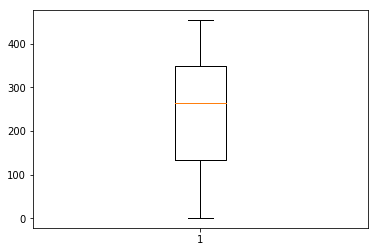

In [34]:
#变量探索，箱线图举例，非必要
plt.boxplot(transaction_risk_sample['city_lst_login'])

In [35]:
#删去无用变量，必要
var_num.remove('uid')
var_num.remove('transaction_datetime')
var_num.remove('target')

In [36]:
from sklearn.preprocessing import StandardScaler

In [39]:
#将连续变量进行标准化处理，必要
for col in var_num:
    print(col)
    SSL = StandardScaler().fit(transaction_risk_sample[col].values.reshape(-1,1))
    transaction_risk_sample[col] = SSL.transform(transaction_risk_sample[col].values.reshape(-1,1))
    transaction_risk_score_sample[col] = SSL.transform(transaction_risk_score_sample[col].values.reshape(-1,1))
    #transaction_risk_sample[col] = StandardScaler().fit_transform(all_data[col].values.reshape(-1,1))

time_sinc_login_sec
timelong_lst_login
log_from_lst_login
city_lst_login
result_lst_login
type_lst_login
scan_login_lst_login
security_login_lst_login
cnt_login
sum_timelong
avg_timelong
cnt_log_from
cnt_ip
cnt_city
cnt_result
cnt_result1_login
cnt_type1_login
cnt_type2_login
cnt_type3_login
cnt_scan1_login
cnt_scan0_login
cnt_sec1_login
cnt_sec0_login
rat_timelong_lst_avg
rat_result1_login
rat_type1_login
rat_type2_login
rat_type3_login
rat_scan1_login
rat_scan0_login
rat_sec1_login


In [40]:
transaction_risk_sample.head(2)

uid transaction_datetime  target  time_sinc_login_sec  timelong_lst_login  \
0    3  2015-01-08 15:00:25       0            -0.336386           -0.018276   
1    4  2015-06-18 11:51:29       0            -0.337240           -0.014732   

   log_from_lst_login  city_lst_login  result_lst_login  type_lst_login  \
0            0.640558       -1.601632          -0.15445        0.873371   
1           -0.935160        1.575053          -0.15445       -1.245157   

   scan_login_lst_login  security_login_lst_login  cnt_login  sum_timelong  \
0              -0.27304                       0.0  -0.351009     -0.034880   
1              -0.27304                       0.0  -0.283040     -0.031406   

   avg_timelong  cnt_log_from    cnt_ip  cnt_city  cnt_result  \
0     -0.018356      -0.82542 -0.429662 -0.556907   -0.865972   
1     -0.013320      -0.82542 -0.223758 -0.556907   -0.865972   

   cnt_result1_login  cnt_type1_login  cnt_type2_login  cnt_type3_login  \
0          -0.290632        -0.205388        -0.157843        -0.248465   
1          -0.217801        -0.064977        -0.157843        -0.300201   

   cnt_scan1_login  cnt_scan0_login  cnt_sec1_login  cnt_sec0_login  \
0        -0.183788        -0.338879             0.0       -0.351009   
1        -0.183788        -0.270356             0.0       -0.283040   

   rat_timelong_lst_avg  rat_result1_login  rat_type1_login  rat_type2_login  \
0             -0.044065             0.7641         -0.81401        -0.318274   
1             -0.274287             0.7641          1.43086        -0.318274   

   rat_type3_login  rat_scan1_login  rat_scan0_login  rat_sec1_login  
0         0.961012         -0.28832          0.28832             0.0  
1        -1.208305         -0.28832          0.28832             0.0

In [41]:
from sklearn.feature_selection import RFE

In [42]:
from sklearn.linear_model import LogisticRegression

In [43]:
#特征筛选，必要

In [44]:
len(var_num)

31

In [45]:
model = LogisticRegression()

In [46]:
rfe = RFE(model, 15)

In [47]:
X = transaction_risk_sample[var_num].values.tolist()

In [48]:
y = transaction_risk_sample['target'].values.tolist()

In [49]:
rfe = rfe.fit(X, y)

In [50]:
print(rfe.support_)

[ True False False False False  True False False  True False False  True
 False  True  True  True False False  True  True  True False  True False
  True False  True False  True  True False]


In [51]:
var_model = []
for i in range(len(rfe.support_)):
    if rfe.support_[i]:
        var_model.append(var_num[i])

In [52]:
len(var_model)

15

In [53]:
var_model

['time_sinc_login_sec',
 'type_lst_login',
 'cnt_login',
 'cnt_log_from',
 'cnt_city',
 'cnt_result',
 'cnt_result1_login',
 'cnt_type3_login',
 'cnt_scan1_login',
 'cnt_scan0_login',
 'cnt_sec0_login',
 'rat_result1_login',
 'rat_type2_login',
 'rat_scan1_login',
 'rat_scan0_login']

# 建立模型

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score

In [57]:
# 分割训练集和测试集,必要
train, test = train_test_split(transaction_risk_sample, test_size=0.7, random_state=22)

In [58]:
#剥离给出的训练集，分成因变量，自变量，必要
X_train = train[var_model]
y_train = train['target']

X_test = test[var_model]
y_test = test['target']

In [59]:
model = LogisticRegression()

In [60]:
lgr = model.fit(X_train, y_train)

# 测试模型

In [61]:
y_pred = lgr.predict_proba(X_test)[:, 1]

In [62]:
y_pred

array([0.0008049 , 0.02598399, 0.02069974, ..., 0.08874674, 0.03648784,
       0.05344241])

In [63]:
#AUC值

In [64]:
roc_auc_score(y_test ,y_pred)

0.7994702419151429

In [65]:
from sklearn.metrics import roc_curve, auc

In [66]:
#计算预测模型的ks和auc
def ks_perf(actuals, predictions):
    fpr, tpr, threshold = roc_curve(actuals, predictions)
    auc_ = auc(fpr, tpr)
    ks_ = max(tpr-fpr)
    print(auc_, ks_)

In [67]:
ks_perf(y_test ,y_pred)

0.7994702419151429 0.46669572074876525


In [68]:
#给出预测结果
test['prob'] = y_pred

E:\anoconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [69]:
test_oos = test[['uid', 'prob', 'target']]

In [70]:
#输出结果
test_oos.to_excel('test_oos.xlsx', index = False)

In [71]:
#对推断集进行预测

In [72]:
x_inference = transaction_risk_score_sample[var_model]

In [73]:
y_inference = lgr.predict_proba(x_inference)[:, 1]

In [76]:
transaction_risk_score_sample['prob'] = y_inference

In [77]:
result = transaction_risk_score_sample[['uid', 'prob']]

In [78]:
result.to_excel('score_sample_prob.xlsx', index = False)